- Not financial or investment advice
- Past performance is not indicative of future results
- I currrently do not invest in this strategy

# Risk On | Risk Off Accelerating Dual Momentum

## Reasoning behind the development of this tactical asset allocation strat
Inspiration for the development of this strategy was built upon previous work by Gary Antonacci's Composite Dual Momentum and by engineeredportfolio.com's Accelerated Dual Momentum. Links below:
- https://allocatesmartly.com/antonaccis-composite-dual-momentum/
- https://engineeredportfolio.com/2018/05/02/accelerating-dual-momentum-investing/

Quick primer on what dual momentum is:
- Momentum can be defined as the rate of change of an asset over N periods
- Dual momentum refers to the usage of absolute/time-series momentum and relative/cross-sectional momentum to make asset selection decisions. 
- Absolute/time-series momentum refers to how an asset's performance compares to it's own prior performance
- Relative/cross-sectional momentum refers to how an asset is performing relative to it's peers or the other assets in the strategy
- Example of asset selection: ETF AAA has the highest momentum score relative to it's peers so it becomes a potential long candidate. If ETF AAA's absolute momentum score is positive go long, if it is negative stay in cash.

A valid concern with both of the above listed strategies is that they have a small pool of investable assets. Mainly between foreign and domestic equities and bonds. Historically this works very well as the above links demonstrate. However, there are points in time when stocks and bonds become correlated. Much like we see in today's stock bond correlation crisis. The current economic backdrop of a declining equity market and a rising rate environment eliminates the negative correlation effects that the above strategies benefit from in times of market stress. An attempt is made to improve upon the original design by increasing the amount of investable assets and splitting the assets into  risk on and risk off buckets. By adding a Commodities ETF and US Dollar ETF we attempt to give the strategy more assets to select from to avoid being stuck with falling assets.

## The Strategy Rules

### Risk On Assets: 
- US Equities = SPY : S&P 500
- Foreign Equities = VEU : Vanguard FTSE All-World ex-US Small ETF
- Commodities = DBC : Invesco DB Commodity Index Tracking Fund

### Risk Off Assets:
- Currency = UUP : Invesco DB US Dollar Index Bullish Fund
- Aggregate Bond Index = AGG : iShares Core US Aggregate Bond ETF
- Long Term Treasuries = TLT : iShares 20+ Year Treasury Bond ETF
- Short Term Treasuries = BIL : SPDR Bloomberg 1-3 Month T-Bill ETF

### Rules:
1. Calculate the 1 month, 3 month, and 6 month return for all assets. The sum of these returns is our signal score. 
2. Select the Risk On ETF that has the highest signal score.
3. If Risk On signal score is positive go long that asset.
4. If Risk On signal score is <= 0 then go long the highest ranked Risk Off ETF

###  Further Refinement/ Research
- Add a REIT ETF and a junk bond/high yield ETF to strategy
- Remove risk on vs risk off baskets and have strategy select top etf monthly
- Multiple rebalance periods throughout the month each managed separately to limit rebalance timing luck
    - Corey Hoffstein writes about this in his paper "Rebalance Timing Luck: The Dumb Luck of Smart Beta
    - https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3673910
    - Additionally, this may have an added benefit of scaling out of falling positions or negatively impact total returns
- Validate the momentum score/signal on a variety of assets and a variety of timeframes to see if signal is robust
    - The main concern here is why was 1, 3, and 6 month returns selected for the above Accelerated Dual Momentum strategy. Was it mined out of the data for maximum performance or was it picked at random. Why not take the sum of all month returns 1 through 6?

In [1]:
# Importing all the necessary packages we will use for our code
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import seaborn as sns
from scipy import stats
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
import yfinance as yf

# Allows entire DataFrame to be displayed when called
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#Pulling the time series data for backtest

#List used for indicator generation
#EASIER IF IN ALPHABETICAL ORDER FOR YFINANCE PULL
symbols = ['AGG', 'BIL', 'DBC', 'SPY', 'TLT', 'UUP', 'VEU']

start_date = '2000-01-01'
end_date = '2022-07-04'
interval = '1d'

price = yf.download(symbols, start=start_date, end=end_date, interval=interval)
price = price.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
price.columns = price.columns.droplevel(0)

#Renaming symbol columns to symbol_price (mandatory)
new_cols_list = ['AGG_Price', 'BIL_Price', 'DBC_Price', 'SPY_Price', 
                 'TLT_Price', 'UUP_Price', 'VEU_Price']
price.columns = new_cols_list

price = price.dropna()
price.head()

[*********************100%***********************]  7 of 7 completed


,AGG_Price,BIL_Price,DBC_Price,SPY_Price,TLT_Price,UUP_Price,VEU_Price
Date,,,,,,,
2007-05-30,63.874531,83.685768,23.596336,113.685402,55.730228,23.826656,37.126415
2007-05-31,63.733223,83.685768,23.811018,113.566833,55.627216,23.788469,37.317547
2007-06-01,63.667309,83.704041,23.988361,114.129807,55.334980,23.798018,37.680046
2007-06-04,63.744778,83.722275,24.203043,114.144646,55.587124,23.702559,37.752552
2007-06-05,63.564045,83.722275,24.109705,113.692802,55.238045,23.635738,37.528458


In [3]:
#Building Indicators and Signal 

#1 Month Return
for symbol in symbols:
    price[str(symbol) + '_ROC_1'] = (price[symbol + '_Price'].shift(1) / price[symbol + '_Price'].shift(22)) - 1

#3 Month Return
for symbol in symbols:
    price[str(symbol) + '_ROC_3'] = (price[symbol + '_Price'].shift(1) / price[symbol + '_Price'].shift(64)) - 1

#6 Month Return
for symbol in symbols:
    price[str(symbol) + '_ROC_6'] = (price[symbol + '_Price'].shift(1) / price[symbol + '_Price'].shift(127)) - 1

#Signal Score
for symbol in symbols:
    price[str(symbol)] = ((price[str(symbol) + '_ROC_1']) + 
                         (price[str(symbol) + '_ROC_3']) +
                         (price[str(symbol) + '_ROC_6']))
    
#Risk On top score
price['Risk_On_Max'] = price[['DBC', 'SPY', 'VEU']].max(axis=1)

#Risk Off top score
price['Risk_Off_Max'] = price[['AGG', 'BIL', 'TLT', 'UUP']].max(axis=1)
    
price = price.dropna()

price.head()

,AGG_Price,BIL_Price,DBC_Price,SPY_Price,TLT_Price,UUP_Price,VEU_Price,AGG_ROC_1,BIL_ROC_1,DBC_ROC_1,SPY_ROC_1,TLT_ROC_1,UUP_ROC_1,VEU_ROC_1,AGG_ROC_3,BIL_ROC_3,DBC_ROC_3,SPY_ROC_3,TLT_ROC_3,UUP_ROC_3,VEU_ROC_3,AGG_ROC_6,BIL_ROC_6,DBC_ROC_6,SPY_ROC_6,TLT_ROC_6,UUP_ROC_6,VEU_ROC_6,AGG,BIL,DBC,SPY,TLT,UUP,VEU,Risk_On_Max,Risk_Off_Max
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-11-28,66.927925,85.615784,28.580688,109.970779,62.025772,22.442497,39.743000,0.014028,0.004829,0.038526,-0.071931,0.050678,-0.017191,-0.054744,0.032992,0.010699,0.220953,-0.003295,0.083518,-0.053312,0.095238,0.050383,0.022840,0.226266,-0.062655,0.120540,-0.060897,0.045269,0.097404,0.038369,0.485745,-0.137881,0.254736,-0.131400,0.085763,0.485745,0.254736
2007-11-29,67.119156,85.559914,28.646027,110.008148,62.560055,22.566593,39.749588,0.011537,0.004172,0.009229,-0.045416,0.039555,-0.012600,-0.044071,0.032525,0.010259,0.194694,0.008789,0.079121,-0.049717,0.090022,0.050126,0.023063,0.200314,-0.031665,0.115026,-0.056581,0.064995,0.094188,0.037494,0.404236,-0.068291,0.233701,-0.118898,0.110946,0.404236,0.233701
2007-11-30,67.257576,85.578560,28.291330,111.114365,62.256557,22.738420,39.769360,0.013120,0.003955,0.034727,-0.038416,0.049087,-0.009220,-0.035657,0.033296,0.009380,0.195093,0.011825,0.081186,-0.048692,0.097943,0.054217,0.022172,0.194164,-0.036114,0.130570,-0.051745,0.054924,0.100634,0.035507,0.423984,-0.062705,0.260843,-0.109657,0.117210,0.423984,0.260843
2007-12-03,67.613098,85.558006,28.496683,110.381851,62.750679,22.690691,39.637535,0.018035,0.003954,-0.006230,-0.038732,0.053512,0.002947,-0.049614,0.034803,0.009820,0.179836,0.012028,0.075093,-0.039129,0.073093,0.055107,0.022172,0.168916,-0.026548,0.119982,-0.040677,0.053422,0.107946,0.035946,0.342523,-0.053252,0.248586,-0.076858,0.076900,0.342523,0.248586
2007-12-04,67.354942,85.576691,28.627357,109.395241,62.744038,22.528410,39.387089,0.020899,0.003034,0.013949,-0.022181,0.048254,-0.002518,-0.030000,0.041438,0.009423,0.175135,-0.004692,0.083111,-0.042690,0.061981,0.063700,0.021926,0.181959,-0.029122,0.136005,-0.039984,0.056199,0.126037,0.034384,0.371043,-0.055995,0.267370,-0.085192,0.088180,0.371043,0.267370


In [4]:
#Creating a daily returns from our prices dataframe
ret = price[['AGG_Price', 'BIL_Price', 'DBC_Price', 'SPY_Price', 
             'TLT_Price', 'UUP_Price', 'VEU_Price']].pct_change()
ret.columns = symbols
ret = ret.dropna()
ret.head()

,AGG,BIL,DBC,SPY,TLT,UUP,VEU
Date,,,,,,,
2007-11-29,0.002857,-0.000653,0.002286,0.000340,0.008614,0.005530,0.000166
2007-11-30,0.002062,0.000218,-0.012382,0.010056,-0.004851,0.007614,0.000497
2007-12-03,0.005286,-0.000240,0.007259,-0.006592,0.007937,-0.002099,-0.003315
2007-12-04,-0.003818,0.000218,0.004586,-0.008938,-0.000106,-0.007152,-0.006318
2007-12-05,-0.001868,0.000000,-0.007499,0.016740,-0.011927,0.012288,0.019076


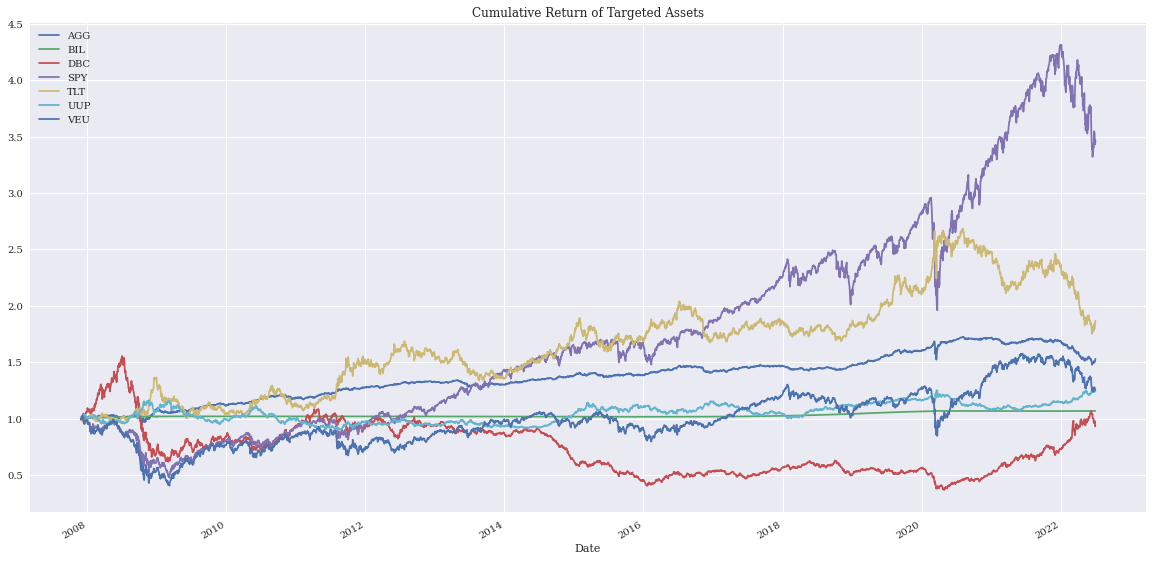

In [5]:
#Plotting the cumulative return of the assets that will be used in the strategy
ret.add(1).cumprod().plot(figsize=(20,10))
plt.title('Cumulative Return of Targeted Assets');

In [6]:
#Getting rebalance dates 

#END OF MONTH REBALANCE

rebal = pd.DataFrame(index=price.index)
rebal['Rebal'] = price.index
rebal['Bool'] = np.where(rebal['Rebal'].dt.month == rebal['Rebal'].dt.month.shift(-1), False, True)
rebal = rebal[rebal.Bool == True]
rebal.head()

,Rebal,Bool
Date,,
2007-11-30,2007-11-30,True
2007-12-31,2007-12-31,True
2008-01-31,2008-01-31,True
2008-02-29,2008-02-29,True
2008-03-31,2008-03-31,True


In [7]:
#List to hold all of our trade returns
trade_pnl_list = []

In [8]:
def select_assets(rb_date):
    positions = []

    for symbol in symbols:
        if price[symbol][rb_date] == price['Risk_On_Max'][rb_date] and price[symbol][rb_date] > 0.0:
            positions.append(symbol)
        elif price['Risk_On_Max'][rb_date] < 0.0 and price[symbol][rb_date] == price['Risk_Off_Max'][rb_date]:
            positions.append(symbol)

    print("-Assets to go Long:\n", positions)
    return positions

def calc_returns(positions, rb_date, next_rb_date):
    #Transaction Costs
    slippage = 0.0010
    next_row = ret.index.get_loc(rb_date)
    next_date = next_row + 1
    for symbol in symbols:
        ret[symbol][next_date] = ret[symbol][next_date] - slippage #Entry slippage
        ret[symbol][next_rb_date] = ret[symbol][next_rb_date] - slippage #Exit slippage
        
    #Getting position returns for period    
    calc_returns_df = ret.loc[rb_date:next_rb_date,positions][1:].add(1).cumprod()
    
    #Getting trade PnL
    for symbol in positions:
        trade_pnl = (calc_returns_df[symbol].iat[-1] - 1).round(4)
        trade_symbol_pnl = (rb_date, symbol, trade_pnl)
        trade_pnl_list.append(trade_symbol_pnl)
        # print(str(symbol), 'Return: ', trade_pnl)
        
    return calc_returns_df

def rebalance(old_portfolio , weights):
    dollar_size = (weights * old_portfolio.sum())
    print('-Dollar Weights:\n', dollar_size)
    return  dollar_size 

def calc_weights(positions, rb_date):
    weights = pd.Series(1.0, index=positions)
    print('-Target Allocation:\n', weights)
    return weights

def update_portfolio_value(portfolio_value, end_values):
    position_returns_df = pd.Series()
    position_returns_df = pd.concat([portfolio_value, end_values.sum(axis=1)])
    return position_returns_df

def get_rebalance_dates(start_delay=0):
    t = pd.DataFrame({'date' : rebal.index[start_delay:]})
    rebal_dates = rebal.index[start_delay:]
    next_days = rebal.index[1:]
    return zip(rebal_dates, next_days)

In [9]:
rebalance_dates = get_rebalance_dates()

In [10]:
def calculate_portfolio_ret():
    #Store to daily total value of the portfolio
    portfolio_value = pd.Series()
    
    #Starting cash amount in portfolio entered into parentheses 
    current_positions = pd.Series(10000)          

    for rb, rb_next in rebalance_dates:          # rb = rebalance date
        
        print('******************************** \n-Rebalance: ', rb)
        positions         = select_assets(rb)  
        weights           = calc_weights(positions, rb)                    
        new_positions     = rebalance(current_positions, weights)
        cum_ret           = calc_returns(positions, rb, rb_next)
        next_values       = cum_ret * new_positions                 
        portfolio_value   = update_portfolio_value(portfolio_value, next_values)
        current_positions = next_values.iloc[-1]               # For next round
        
    portfolio_return = portfolio_value.pct_change().to_frame('Strategy')
    
    #Daily portfolio returns
    return portfolio_return   

In [11]:
pr = calculate_portfolio_ret()
pr

******************************** 
-Rebalance:  2007-11-30 00:00:00
-Assets to go Long:
 ['DBC']
-Target Allocation:
 DBC    1.0
dtype: float64
-Dollar Weights:
 DBC    10000.0
dtype: float64
******************************** 
-Rebalance:  2007-12-31 00:00:00
-Assets to go Long:
 ['DBC']
-Target Allocation:
 DBC    1.0
dtype: float64
-Dollar Weights:
 DBC    10649.184925
dtype: float64
******************************** 
-Rebalance:  2008-01-31 00:00:00
-Assets to go Long:
 ['DBC']
-Target Allocation:
 DBC    1.0
dtype: float64
-Dollar Weights:
 DBC    10938.056228
dtype: float64
******************************** 
-Rebalance:  2008-02-29 00:00:00
-Assets to go Long:
 ['DBC']
-Target Allocation:
 DBC    1.0
dtype: float64
-Dollar Weights:
 DBC    12132.416283
dtype: float64
******************************** 
-Rebalance:  2008-03-31 00:00:00
-Assets to go Long:
 ['DBC']
-Target Allocation:
 DBC    1.0
dtype: float64
-Dollar Weights:
 DBC    11997.359097
dtype: float64
*************************

,Strategy
2007-12-03,NaN
2007-12-04,4.585599e-03
2007-12-05,-7.499177e-03
2007-12-06,1.806823e-02
2007-12-07,-3.226781e-03
2007-12-10,-6.473660e-04
2007-12-11,8.746294e-03
2007-12-12,2.729611e-02
2007-12-13,-1.062833e-02
2007-12-14,-6.951064e-03


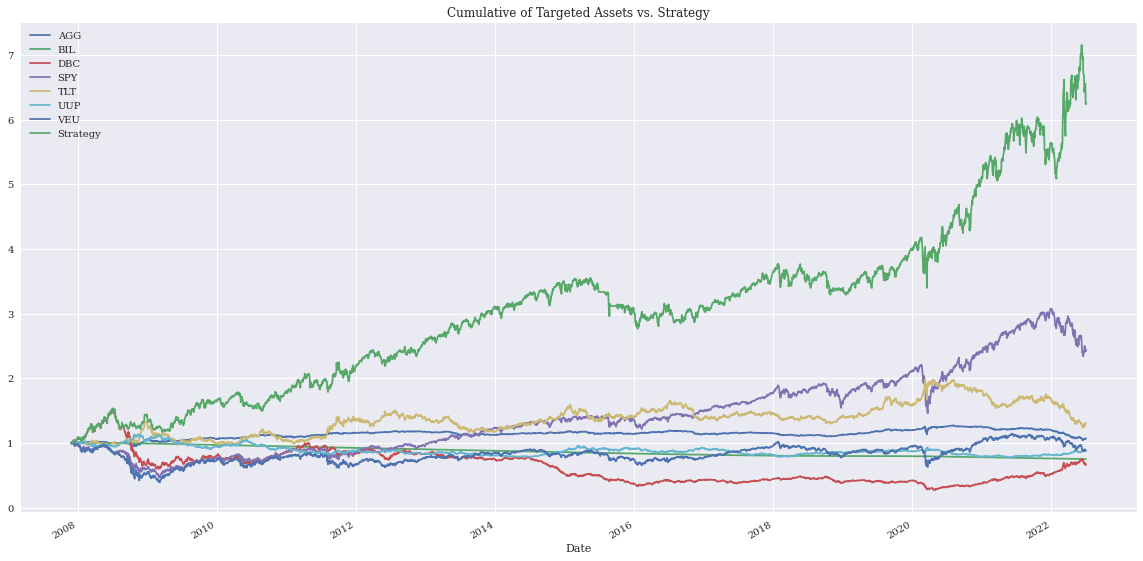

In [12]:
all_ret = ret.join(pr)
all_ret.add(1).cumprod().plot(figsize=(20,10))
plt.title('Cumulative of Targeted Assets vs. Strategy');

In [13]:
trade_pnl_df = pd.DataFrame(trade_pnl_list, columns=['Date', 'Symbol', 'PnL'])
trade_pnl_df = trade_pnl_df.set_index('Date')
trade_pnl_df.tail()

,Symbol,PnL
Date,,
2022-02-28,DBC,0.0896
2022-03-31,DBC,0.0543
2022-04-29,DBC,0.0440
2022-05-31,DBC,-0.0769
2022-06-30,DBC,0.0029


In [14]:
position_counts = trade_pnl_df.Symbol.value_counts()
position_counts

SPY    76
DBC    47
VEU    30
TLT    13
UUP     8
BIL     2
Name: Symbol, dtype: int64

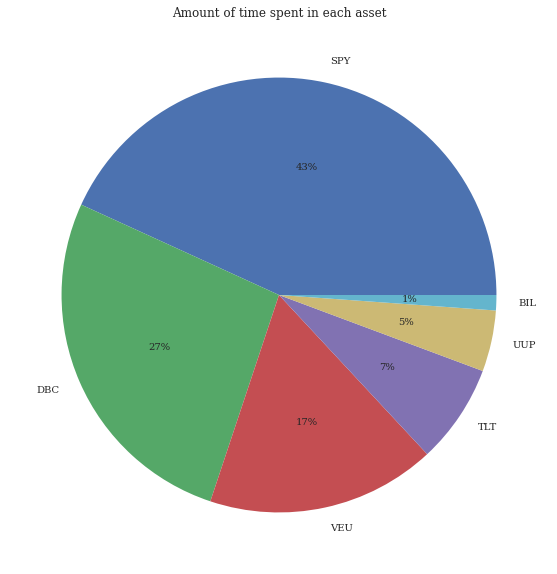

In [15]:
plt.figure(figsize=(20,10))
plt.pie(position_counts, labels=['SPY', 'DBC', 'VEU', 'TLT', 'UUP', 'BIL'], autopct='%1.0f%%')
plt.title('Amount of time spent in each asset')
plt.show();

In [16]:
#Key Performance Metrics

#Importing a package that has some great analysis
#Link to the author's git https://github.com/ranaroussi/quantstats

%matplotlib inline
import quantstats as qs

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2007-12-03  2007-12-03
End Period                 2022-07-01  2022-07-01
Risk-Free Rate             0.0%        0.0%
Time in Market             99.0%       100.0%

Cumulative Return          525.83%     245.38%
CAGR﹪                     13.4%       8.87%

Sharpe                     0.79        0.52
Smart Sharpe               0.78        0.51
Sortino                    1.11        0.72
Smart Sortino              1.1         0.71
Sortino/√2                 0.79        0.51
Smart Sortino/√2           0.78        0.5
Omega                      1.15        1.15

Max Drawdown               -23.7%      -53.89%
Longest DD Days            900         1554
Volatility (ann.)          18.0%       20.64%
R^2                        0.08        0.08
Calmar                     0.57        0.16
Skew                       -0.37       -0.07
Kurtosis                   4.36        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-07-03,2009-03-19,2009-09-08,432,-23.701885,-23.059700
2,2015-05-18,2016-01-20,2017-11-03,900,-22.146431,-20.812886
3,2020-02-20,2020-03-18,2020-06-03,104,-18.660070,-16.445579
4,2010-04-26,2010-08-24,2010-11-04,192,-16.315033,-16.191836
5,2021-10-21,2022-01-27,2022-03-02,132,-15.780819,-15.362879


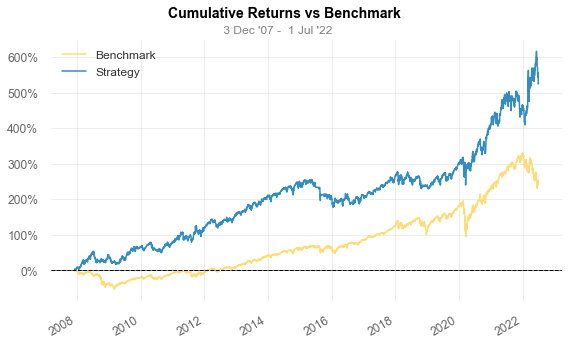

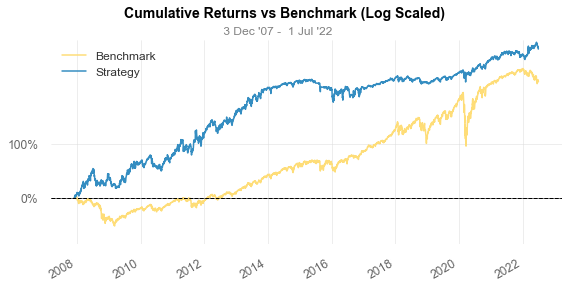

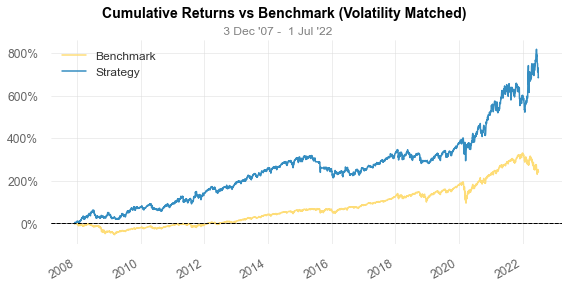

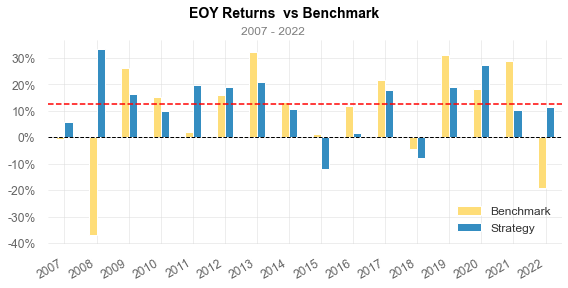

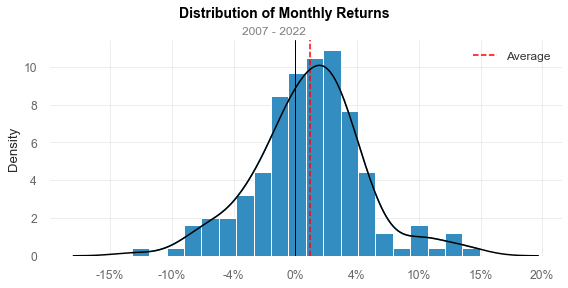

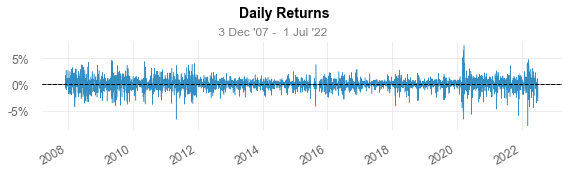

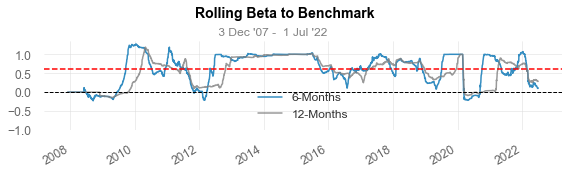

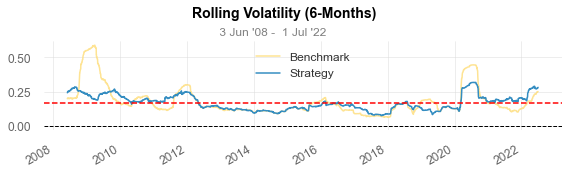

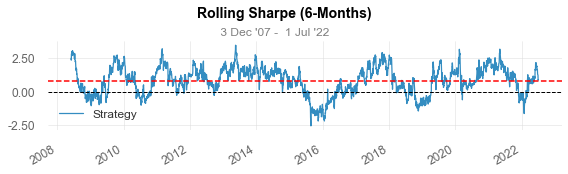

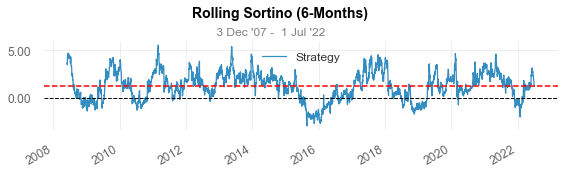

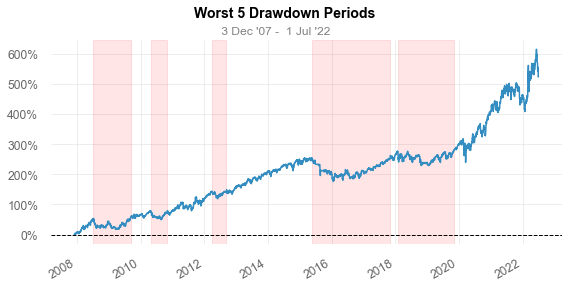

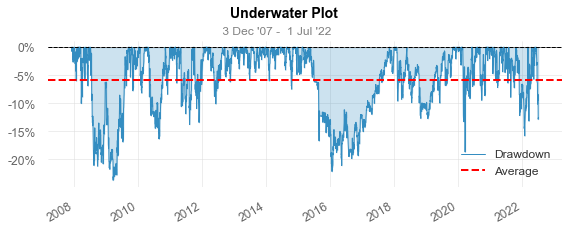

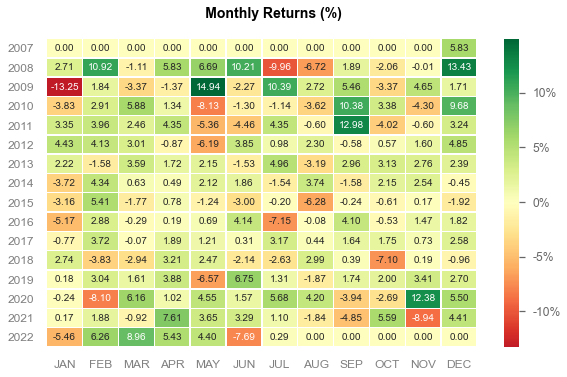

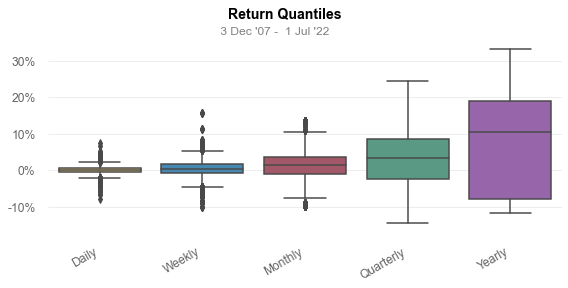

In [17]:
qs.reports.full(pr.Strategy, "SPY")

## Monte Carlo Simulation

Here we will use a monte carlo simulation on the trade results from the above strategy. The intent here is to get an idea of what a worst case scenario might look like. Additionaly the results of each run will be plotted and we will gather some basic risk metrics off the simulation results.

Note: Our performance metrics will be slightly different than above since our trade returns are montly where as the portfolio returns are daily returns above.

In [18]:
#Creating functions for the performance metrics we would like to see on each run

def total_return_plot(x):
    total_return = x.add(1).cumprod()
    return total_return

def max_drawdown(x):
    NAV = x.add(1).cumprod() * 100
    Roll_Max = NAV.expanding().max()
    dd = (NAV/Roll_Max - 1.0)
    max_dd = dd.expanding().min()
    return max_dd[-1:]

def calmar_ratio(x):
    annual_ret = (x.add(1).cumprod() ** (1 / (len(x) / 12))) - 1
    NAV = x.add(1).cumprod() * 100
    Roll_Max = NAV.expanding().max()
    dd = (NAV/Roll_Max - 1.0)
    max_dd = dd.expanding().min()
    calmar = abs(annual_ret / max_dd)
    return calmar[-1:]

In [19]:
def mc_sim(x, simulations=1000, frac=1):
    '''
    x = pd.Series of our trade returns
    simulations = number of runs we would like to conduct, default is 1000
    frac = the percentage of values we would like to sample from the sample data, default is 100%
    '''
    
    #Setting up out plot of all the individual runs
    plt.figure(figsize=(20,10))
    plt.title('Monte Carlo Simulation on Strategy Trade Returns')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    
    #Creating empty lists to handle all the output from the for loop
    max_drawdowns = []
    calmar_ratios = []
    
    #Looping over randomized returns for simulation, had to do some janky stuff with pandas here
    for i in range(simulations):
        pre_run = x.reset_index(drop=True)
        sim_run = pre_run.sample(frac=frac)
        sim_run = sim_run.reset_index()
        sim_run = sim_run.drop(['index'], axis=1)
        sim_run = sim_run.squeeze()
       
        max_drawdowns.append(max_drawdown(sim_run))
        calmar_ratios.append(calmar_ratio(sim_run))
        
        plt.plot(total_return_plot(sim_run))
    
    #More janky pandas stuff to get data to print cleanly
    max_drawdowns_df = pd.DataFrame(max_drawdowns)
    max_drawdowns_df = max_drawdowns_df.reset_index(drop=True)
    max_drawdowns_df.columns = ['Max_Drawdowns']
    calmar_ratios_df = pd.DataFrame(calmar_ratios)
    calmar_ratios_df = calmar_ratios_df.reset_index(drop=True)
    calmar_ratios_df.columns = ['Calmar Ratios']
    
    plt.show()
    
    #Printing all the metrics we want to see
    print('***   Max Drawdown Stats   ***')
    print('-Largest Max Drawdown in Simulation: ', max_drawdowns_df.min().to_string()) 
    print('-Smallest Max Drawdown in Simulation: ', max_drawdowns_df.max().to_string())
    print('-Average of all Max Drawdowns in Simulation: ', max_drawdowns_df.mean().to_string())
    print('\n***   Calmar Ratio Stats   ***')
    print('-Largest Calmar Ratio in Simulation: ', calmar_ratios_df.max().to_string())
    print('-Smallest Calmar Ratio in Simulation: ', calmar_ratios_df.min().to_string())
    print('-Average of all Calmar Ratios in Simulation: ', calmar_ratios_df.mean().to_string())

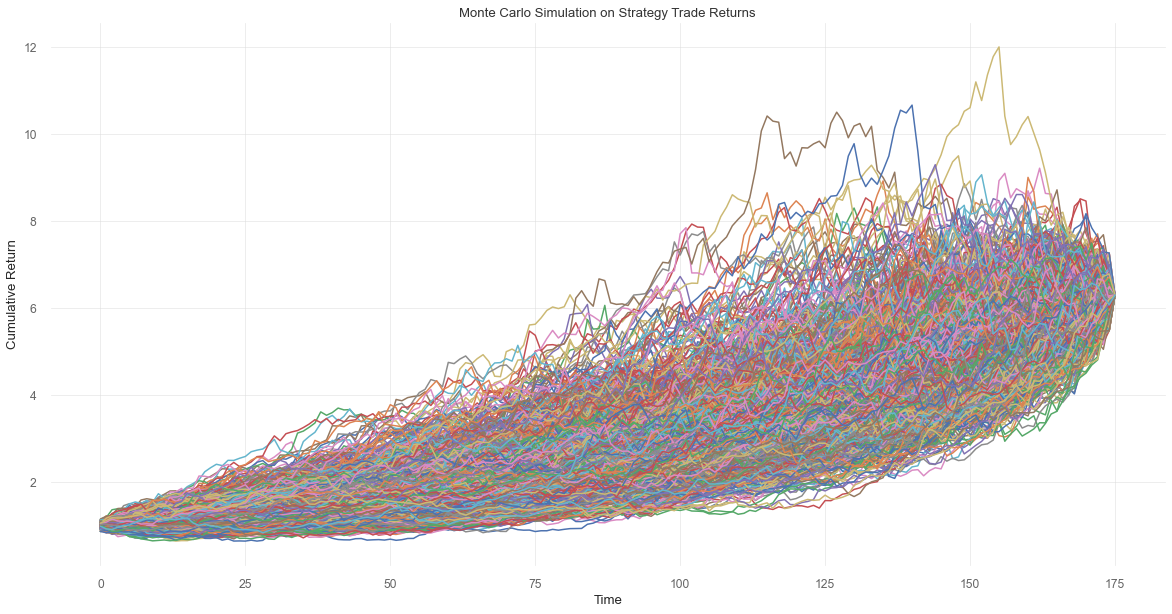

***   Max Drawdown Stats   ***
-Largest Max Drawdown in Simulation:  Max_Drawdowns   -0.489428
-Smallest Max Drawdown in Simulation:  Max_Drawdowns   -0.1325
-Average of all Max Drawdowns in Simulation:  Max_Drawdowns   -0.251893

***   Calmar Ratio Stats   ***
-Largest Calmar Ratio in Simulation:  Calmar Ratios    1.008905
-Smallest Calmar Ratio in Simulation:  Calmar Ratios    0.273135
-Average of all Calmar Ratios in Simulation:  Calmar Ratios    0.559784


In [20]:
#Assigning a variable to handle the trade returns and calling our mc_sim function
trade_returns = trade_pnl_df.PnL
mc_sim(trade_returns, simulations=1000, frac=1)

Strategy Maximum Drawdown:
 Date
2022-06-30   -0.199596

Strategy Calmar Ratio:
 Date
2022-06-30    0.669752


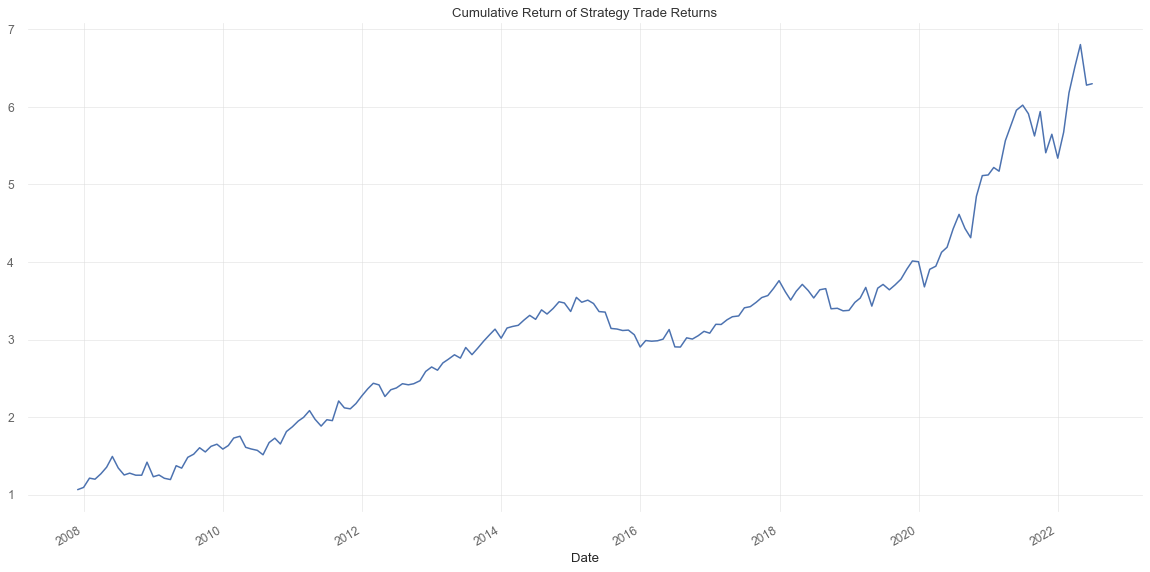

In [21]:
# The strategy for comparison

plt.title('Cumulative Return of Strategy Trade Returns')
plt.xlabel('Cumulative Return')
trade_returns.add(1).cumprod().plot(figsize=(20,10));

max_dd = max_drawdown(trade_returns)
calmar = calmar_ratio(trade_returns)

print('Strategy Maximum Drawdown:\n', max_dd.to_string())
print('\nStrategy Calmar Ratio:\n', calmar.to_string())

### Final Thoughts

The maximum drawdown seen throughout the backtest is double what I would be comfortable with despite it being half what the benchmark experienced in the same time frame. Additionally, looking at the longest drawdown days, 900 days, I have to ask myself would I be able to sit through a drawdown for over two years? My gut answer is no. I think I would abandon the strategy in pursuit of something else. Further research is needed. My plan for that is posted in the top markdown cell.